In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [2]:
df = pd.read_csv("waqi_global_dataset_with_categoricals.csv")

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (12815, 20)
     uid                 time    aqi            city_name        lat  \
0    428  2025-09-21 01:00:00  107.0        Osorno, Chile -40.584479   
1   8821  2025-09-21 01:00:00   63.0       Mirasol, Chile -41.479507   
2  14756  2025-09-21 02:00:00   46.0  Puerto Varas, Chile -41.328935   
3    445  2025-09-21 02:00:00  152.0     Coyhaique, Chile -45.579964   
4  10699  2025-09-21 01:00:00   38.0      Vialidad, Chile -45.406800   

         lon   pm25  pm10  no2  so2  co  o3  temp_c  humidity_pct  \
0 -73.118720  107.0  37.0  NaN  NaN NaN NaN     8.7          93.8   
1 -72.968756   63.0   NaN  NaN  NaN NaN NaN     8.0          93.0   
2 -72.968209   46.0  12.0  NaN  NaN NaN NaN     8.0          93.0   
3 -72.061126  152.0  46.0  NaN  NaN NaN NaN     6.0          87.0   
4 -72.696260   38.0   NaN  NaN  NaN NaN NaN     6.0          93.0   

   pressure_hpa  wind_speed_mps             aqi_category  month  season  \
0        1008.3             0.9  Unhealthy for Sen

In [3]:
before = df.shape[0]
df = df.drop_duplicates()
print(f"Removed {before - df.shape[0]} duplicate rows")

Removed 0 duplicate rows


In [4]:
target = "aqi_category"
X = df.drop(columns=[target])
y = df[target]

In [5]:
# Separate numeric & categorical
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

In [6]:
# Force numeric conversion (turn invalid strings → NaN)
for c in num_features:
    X[c] = pd.to_numeric(X[c], errors="coerce")


In [7]:
# Fill numeric NaNs with mean
for c in num_features:
    X[c] = X[c].fillna(X[c].mean())

# Fill categorical NaNs with mode
for c in cat_features:
    X[c] = X[c].fillna(X[c].mode()[0])

# Drop rows with missing target
mask = y.notna()
X, y = X[mask], y[mask]

In [8]:
# --------------------------
# 4) Handle outliers (IQR capping)
# --------------------------
def cap_outliers(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return s.clip(lower, upper)

for c in num_features:
    X[c] = cap_outliers(X[c])

In [9]:
# --------------------------
# 5) Encode categorical vars
# --------------------------
le_dict = {}
for c in cat_features:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c])
    le_dict[c] = le

# Encode target
le_target = LabelEncoder()
y_enc = le_target.fit_transform(y)

In [10]:
# --------------------------
# 6) Feature–target correlation
# --------------------------
corrs = {}
for c in X.columns:
    corrs[c] = np.corrcoef(X[c], y_enc)[0, 1]
corrs = pd.Series(corrs).sort_values(ascending=False)
print("\n=== Correlation of Features vs Target (Encoded AQI) ===")
print(corrs)


=== Correlation of Features vs Target (Encoded AQI) ===
aqi               0.758056
pm25              0.707760
pm10              0.536691
no2               0.247152
temp_c            0.198663
so2               0.172190
lon               0.159945
co                0.112956
uid               0.043426
season            0.014225
city_name         0.009648
humidity_pct     -0.015555
o3               -0.025879
time             -0.044472
temp_condition   -0.048802
wind_speed_mps   -0.085050
pressure_hpa     -0.142152
lat              -0.227862
month                  NaN
dtype: float64


c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [11]:
# --------------------------
# 7) Feature importance (Ensemble-based)
# --------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y_enc)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns)

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X, y_enc)
gb_importances = pd.Series(gb.feature_importances_, index=X.columns)

feature_importance = pd.DataFrame({
    "RandomForest": rf_importances,
    "GradientBoosting": gb_importances
})
feature_importance["Mean"] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values("Mean", ascending=False)

print("\n=== Feature Importance (RF + GB aggregated) ===")
print(feature_importance)

# Select top features (ensemble-based selection)
top_features = feature_importance.index[1:8].tolist()
print("\nSelected Best Features:", top_features)

X_selected = X[top_features]



=== Feature Importance (RF + GB aggregated) ===
                RandomForest  GradientBoosting      Mean
aqi                 0.434452          0.951103  0.692778
pm25                0.332351          0.015406  0.173879
pm10                0.063504          0.001271  0.032387
lon                 0.024903          0.006733  0.015818
lat                 0.018029          0.003099  0.010564
no2                 0.014792          0.001431  0.008111
co                  0.014418          0.000950  0.007684
temp_c              0.012083          0.003029  0.007556
uid                 0.012129          0.002385  0.007257
so2                 0.012508          0.001620  0.007064
time                0.010758          0.002548  0.006653
humidity_pct        0.010317          0.002724  0.006520
city_name           0.010371          0.002095  0.006233
o3                  0.010476          0.001381  0.005928
wind_speed_mps      0.008374          0.003336  0.005855
pressure_hpa        0.008876          0

In [12]:
# --------------------------
# 8) Train-Test Split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)



In [13]:
# --------------------------
# 9) Preprocessor (numeric pipeline only)
# --------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), top_features)
    ]
)


=== Logistic Regression ===
Accuracy: 0.9266
                         precision    recall  f1-score   support

                   Good       0.96      0.98      0.97      2023
              Hazardous       0.00      0.00      0.00         4
               Moderate       0.78      0.87      0.82       450
              Unhealthy       0.00      0.00      0.00        15
Unhealthy for Sensitive       0.57      0.09      0.15        47
                Unknown       0.00      0.00      0.00        23
         Very Unhealthy       0.00      0.00      0.00         1

               accuracy                           0.93      2563
              macro avg       0.33      0.28      0.28      2563
           weighted avg       0.91      0.93      0.91      2563



c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

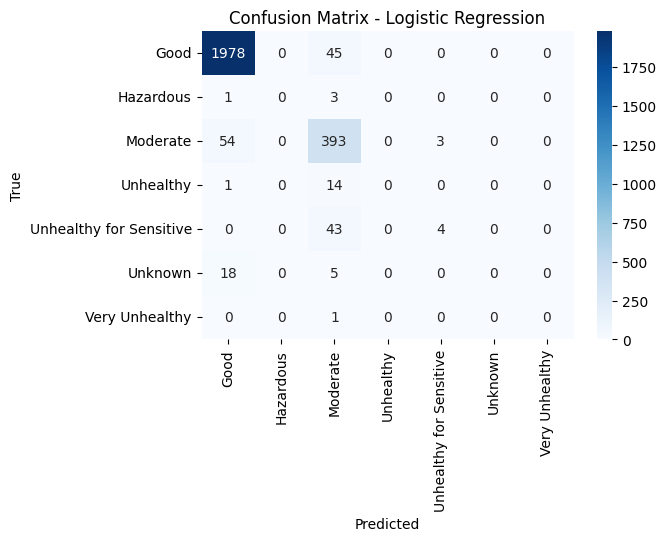


=== Random Forest ===
Accuracy: 0.9528
                         precision    recall  f1-score   support

                   Good       0.98      0.99      0.99      2023
              Hazardous       0.00      0.00      0.00         4
               Moderate       0.89      0.91      0.90       450
              Unhealthy       0.10      0.07      0.08        15
Unhealthy for Sensitive       0.41      0.40      0.41        47
                Unknown       1.00      0.22      0.36        23
         Very Unhealthy       0.00      0.00      0.00         1

               accuracy                           0.95      2563
              macro avg       0.48      0.37      0.39      2563
           weighted avg       0.95      0.95      0.95      2563



c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Kesi2\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

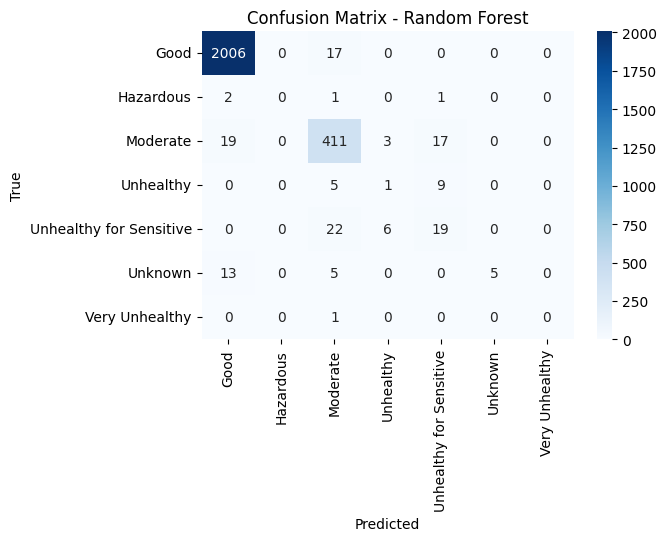


=== Gradient Boosting ===
Accuracy: 0.9544
                         precision    recall  f1-score   support

                   Good       0.98      0.99      0.99      2023
              Hazardous       0.00      0.00      0.00         4
               Moderate       0.91      0.91      0.91       450
              Unhealthy       0.50      0.33      0.40        15
Unhealthy for Sensitive       0.44      0.49      0.46        47
                Unknown       0.71      0.22      0.33        23
         Very Unhealthy       0.50      1.00      0.67         1

               accuracy                           0.95      2563
              macro avg       0.58      0.56      0.54      2563
           weighted avg       0.95      0.95      0.95      2563



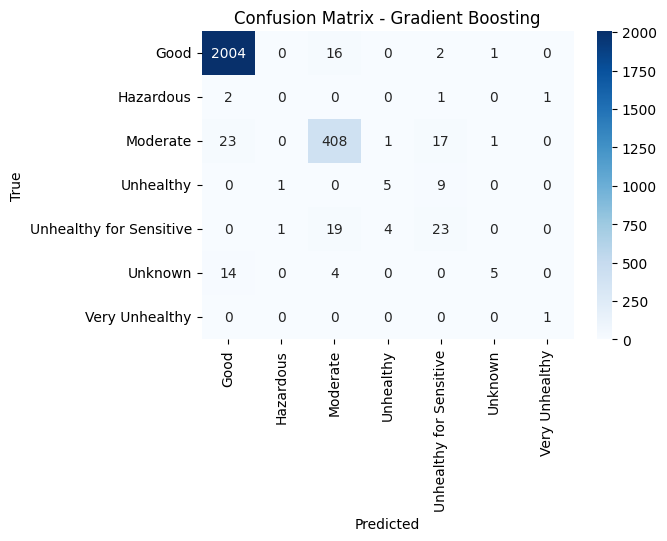

In [14]:
# --------------------------
# 10) Train & Evaluate Models
# --------------------------
def train_and_evaluate(model, model_name):
    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {model_name} ===")
    print("Accuracy:", round(acc, 4))
    print(classification_report(y_test, y_pred, target_names=le_target.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le_target.classes_,
                yticklabels=le_target.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



    # Run models
train_and_evaluate(LogisticRegression(max_iter=1000), "Logistic Regression")
train_and_evaluate(RandomForestClassifier(n_estimators=200, random_state=42), "Random Forest")
train_and_evaluate(GradientBoostingClassifier(random_state=42), "Gradient Boosting")

In [15]:
# --------------------------
# 11) Save Final Model
# --------------------------
final_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

final_model.fit(X_train, y_train)

joblib.dump(final_model, "aqi_predictor_with_pm.pkl")
joblib.dump(le_target, "label_encoder.pkl")

print("✅ Final model & encoder saved successfully!")

✅ Final model & encoder saved successfully!
